# Convert `GeoTIFFs` in Google Cloud Storage to `Zarr`

In [1]:
import numpy as np
import pandas as pd
from osgeo import gdal
import xarray as xr
import dask.array as da
import zarr
import rioxarray
import gcsfs
import s3fs
import matplotlib.pyplot as plt
import os
import json
from google.cloud import storage

In [2]:
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

## Utils

**download_blob**

In [3]:
def download_blob(bucket_name, blob_name, file_name):
    storage_client = storage.Client.from_service_account_json(os.getenv('PRIVATEKEY_PATH'))
        
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)
    
    blob.download_to_filename(file_name)
    
    print(
        "File {} downloaded to {}.".format(
            blob_name, file_name
        )
    )

**change_compression**

In [4]:
input_tiff = '../data/scenario_crop_MG_SOC_Y05.tif'
output_tiff = '../data/scenario_crop_MG_SOC_Y05_new.tif'  

def change_compression(input_tiff, output_tiff, compression='LZW'):
    translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine(f"-of Gtiff -co COMPRESS={compression}"))
    gdal.Translate(output_tiff, input_tiff, options=translateoptions)

## From `GeoTIFFs` to `Zarr`

We use the [xarray](http://xarray.pydata.org/en/stable/io.html#reading-and-writing-files) library to convert `GeoTIFFs` into `Zarr`. 

GeoTIFFs can be opened using [rasterio](http://xarray.pydata.org/en/stable/io.html#rasterio) with this xarray method: `xarray.open_rasterio`. Additionally, you can use [rioxarray](https://corteva.github.io/rioxarray/stable/) for reading GeoTiffs.

To save `xarray.Datasets` as a `Zarr` we can us the [Xarray’s Zarr backend](http://xarray.pydata.org/en/stable/io.html#zarr). [Zarr](http://zarr.readthedocs.io/) is a Python package providing an implementation of chunked, compressed, N-dimensional arrays. Zarr has the ability to read and write xarray datasets directly from / to cloud storage buckets such as Amazon S3 and Google Cloud Storage.

Xarray needs to read all of the zarr metadata when it opens a dataset. With version 2.3, Zarr will support a feature called consolidated metadata, which allows all metadata for the entire dataset to be stored with a single key (by default called `.zmetadata`). This can drastically speed up opening the store. To write consolidated metadata, pass the `consolidated=True` option to the `Dataset.to_zarr` method.

***
## Create `xarray.Dataset` on disk

### Argentina SOC stocks dataset

**Data location:**

https://storage.cloud.google.com/vizz-data-transfer/SOC_maps/

**Data description:**

The name structure of the files is `Feb19_cstocks_YEAR_030_ll.tif`:
- YEAR: 1982-2017
- The stocks were calculated in the 0 to 30 cm interval. 

**Output data location:**
 
https://soils-revealed.s3.amazonaws.com/experimental-dataset.zarr/

**Amazon S3 bucket**

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_stock/'
# AWS S3 path
s3_path = 's3://soils-revealed/experimental-dataset.zarr' 
group = 'stocks'

ds_name = 'stocks'
# Initilize the S3 file system
s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))

times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
depth = ['0-30']
years = np.arange(1982, 2018, 1).astype(np.str)

for i, year in enumerate(years):
    print(f'Year: {year}')
    url = base_url + 'Feb19_cstocks_' + year + '_030_ll.tif'
    xda = xr.open_rasterio(url).squeeze().drop("band")
    
    # replace all values equal to -9999 with np.nan
    xda = xda.where(xda != -9999.) 
    
    # add time and depth coordinates
    #xda = xda.assign_coords({"depth": depth[0], "time": times[i]}).expand_dims(['depht', 'time'])
    xda = xda.assign_coords({"time": times[i]}).expand_dims(['time'])
    
    # convert to Dataset
    xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
    
    # add depth coordinate
    xds = xds.assign_coords({"depth": np.array([depth[0]])})
    
    # select sub-area
    #xds = xds.isel(x=slice(2000, 2100), y=slice(4000, 4100))
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:
        # Save in S3
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        xds.to_zarr(store=store, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(store)
        c = s3.exists(f"{s3_path}/.zmetadata")
        print(f"{s3_path} is consoldiated? {c}")
        with zarr.open(store, mode='r') as z:
            print(z.tree())
        
        ## Save locally
        #xds.to_zarr(local_path, group=group, mode='w', consolidated=True)
        ## consolidate metadata at root
        #zarr.consolidate_metadata(local_path)
        #with zarr.open(local_path, mode='r') as z:
        #    print(z.tree())
    else:
        # Save in S3
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        xds.to_zarr(store=store, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(store)
        c = s3.exists(f"{s3_path}/.zmetadata")
        print(f"{s3_path} is consoldiated? {c}")
        with zarr.open(store, mode='r') as z:
            print(z.tree())
        
        ## Save locally
        #xds.to_zarr(local_path, group=group, append_dim='time', consolidated=True)
        ## consolidate metadata at root
        #zarr.consolidate_metadata(local_path)
        #with zarr.open(local_path, mode='r') as z:
        #    print(z.tree())

**Output data location:**
 
../data/experimental-dataset.zarr/

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_stock/'
# Local path
path = '../data/experimental-dataset.zarr' 
group = 'stocks'

ds_name = 'stocks'

times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
depth = ['0-30']
years = np.arange(1982, 2018, 1).astype(np.str)

bucket_name = 'vizz-data-transfer'
file_path = 'SOC_maps/SOC_stock/'

for i, year in enumerate(years):
    print(f'Year: {year}')
    file_name = 'Feb19_cstocks_' + year + '_030_ll.tif'
    url = base_url + file_name
    
    # Download tiff
    download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
    
    # Read tiff
    xda = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")
    
    # Remove tiff
    os.remove(f'../data/{file_name}')
        
    # replace all values equal to -9999 with np.nan
    xda = xda.where(xda != -9999.) 
    
    # add time and depth coordinates
    #xda = xda.assign_coords({"depth": depth[0], "time": times[i]}).expand_dims(['depht', 'time'])
    xda = xda.assign_coords({"time": times[i]}).expand_dims(['time'])
    
    # convert to Dataset
    xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
    
    # add depth coordinate
    xds = xds.assign_coords({"depth": np.array([depth[0]])})
    
    # select sub-area
    #xds = xds.isel(x=slice(2000, 2100), y=slice(4000, 4100))
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:   
        # Save
        xds.to_zarr(store=path, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

    else:
        # Save
        xds.to_zarr(store=path, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

### Argentina SOC concentration dataset

**Input data location:**

https://storage.cloud.google.com/vizz-data-transfer/SOC_maps/

**Data description:**

The name structure of the files is `SOC_YEAR_qQUANTILE_dDEPTH.tif`:

- YEAR: 1982-2017
- QUANTILE: 0.05,0.5,0.95 percentiles
- DEPTH:
    - 2.5 --> for the interval 0-5cm
    - 10 --> for the interval 5-15cm
    - 22.5 --> for the interval 15-30cm
    - 45 --> for the interval 30-60cm
    - 80 --> for the interval 60-100cm
    - 150 --> for the interval 100-200cm
    
**Output data location:**
 
https://soils-revealed.s3.amazonaws.com/experimental-dataset.zarr/

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_concentration/'
# AWS S3 path
#s3_path = 's3://soils-revealed/soil-data.zarr' 
s3_path = 's3://soils-revealed/experimental-dataset.zarr' 
group = 'concentration'

ds_name = 'concentration'

# Initilize the S3 file system
s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))

times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
depths = {'0-5': '2.5', '5-15': '10', '15-30': '22.5', '30-60': '45', '60-100': '80', '100-200': '150'}
years = np.arange(1982, 2018, 1).astype(np.str)

for i, year in enumerate(years):
    print(f'Year: {year}')
    for depth,dname in depths.items():
        print(f'Depth: {depth}')
        url = base_url + 'SOC_' + year + '_q0.5_d'+ dname + '.tif'
        
        xda = xr.open_rasterio(url).squeeze().drop("band")
        
        # replace all values equal to 0 with np.nan
        xda = xda.where(xda != 0) 

        # add time and depth coordinates
        xda = xda.assign_coords({"time": times[i]}).expand_dims(['time'])
        
        # convert to Dataset and concatenate by depth
        if depth == '0-5':
            xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds = xds.assign_coords({"depth": np.array([depth])})
        else:
            xds_depth = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds_depth = xds_depth.assign_coords({"depth": np.array([depth])})
            
            xds = xr.concat([xds, xds_depth], dim='depth')
        
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:
        # Save in S3
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        xds.to_zarr(store=store, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(store)
        c = s3.exists(f"{s3_path}/.zmetadata")
        print(f"{s3_path} is consoldiated? {c}")
        with zarr.open(store, mode='r') as z:
            print(z.tree())
    else:
        # Save in S3
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        xds.to_zarr(store=store, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(store)
        c = s3.exists(f"{s3_path}/.zmetadata")
        print(f"{s3_path} is consoldiated? {c}")
        with zarr.open(store, mode='r') as z:
            print(z.tree())

**Output data location:**
 
../data/experimental-dataset.zarr/

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_concentration/'
# Local path
path = '../data/experimental-dataset.zarr' 
group = 'concentration'

ds_name = 'concentration'

times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
depths = {'0-5': '2.5', '5-15': '10', '15-30': '22.5', '30-60': '45', '60-100': '80', '100-200': '150'}
years = np.arange(1982, 2018, 1).astype(np.str)

bucket_name = 'vizz-data-transfer'
file_path = 'SOC_maps/SOC_concentration/'

for i, year in enumerate(years):
    print(f'Year: {year}')
    for depth,dname in depths.items():
        print(f'Depth: {depth}')
        file_name = 'SOC_' + year + '_q0.5_d'+ dname + '.tif'
        url = base_url + file_name
        
        # Download tiff
        download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
        
        # Read tiff
        xda = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")
        
        # Remove tiff
        os.remove(f'../data/{file_name}')
        
        # replace all values equal to 0 with np.nan
        xda = xda.where(xda != 0) 

        # add time and depth coordinates
        xda = xda.assign_coords({"time": times[i]}).expand_dims(['time'])
        
        # convert to Dataset and concatenate by depth
        if depth == '0-5':
            xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds = xds.assign_coords({"depth": np.array([depth])})
        else:
            xds_depth = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds_depth = xds_depth.assign_coords({"depth": np.array([depth])})
            
            xds = xr.concat([xds, xds_depth], dim='depth')
        
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:
        # Save
        xds.to_zarr(store=path, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

    else:
        # Save
        xds.to_zarr(store=path, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

### Historic SOC stocks dataset

**Data location:**

https://soils-revealed.s3.amazonaws.com/SOC_maps/Historic/

**Data description:**

The name structure of the files is `SOCS_DEPTH_year_YEAR_10km.tif`:
- DEPTH: 0_30cm, 0_100cm, 0_200cm
- YEAR: NoLU, 2010AD 

**Output data location:**
 
https://soils-revealed.s3.amazonaws.com/global-dataset.zarr/

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Historic/'
# AWS S3 path
s3_path = 's3://soils-revealed/global-dataset.zarr' 
group = 'historic'

ds_name = 'stocks'
# Initilize the S3 file system
s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))

depths = {'0-30': '0_30', '0-100': '0_100', '0-200': '0_200'}
years = ['NoLU', '2010AD']

for i, year in enumerate(years):
    print(f'Year: {year}')
    for depth,dname in depths.items():
        print(f'Depth: {depth}')
        url = base_url + 'SOCS_' + dname +'cm_year_' + year +'_10km.tif'
        
        xda = xr.open_rasterio(url).squeeze().drop("band")
        
        # replace all values equal to 0 with np.nan
        xda = xda.where(xda != -32767.0) 

        # add time and depth coordinates
        xda = xda.assign_coords({"time": year}).expand_dims(['time'])
        
        # convert to Dataset and concatenate by depth
        if depth == '0-30':
            xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds = xds.assign_coords({"depth": np.array([depth])})
        else:
            xds_depth = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds_depth = xds_depth.assign_coords({"depth": np.array([depth])})
            
            xds = xr.concat([xds, xds_depth], dim='depth')
        
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:
        # Save in S3
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        xds.to_zarr(store=store, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(store)
        c = s3.exists(f"{s3_path}/.zmetadata")
        print(f"{s3_path} is consoldiated? {c}")
        with zarr.open(store, mode='r') as z:
            print(z.tree())
    else:
        # Save in S3
        store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
        xds.to_zarr(store=store, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(store)
        c = s3.exists(f"{s3_path}/.zmetadata")
        print(f"{s3_path} is consoldiated? {c}")
        with zarr.open(store, mode='r') as z:
            print(z.tree())

**Output data location:**
 
../data/global-dataset.zarr/

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Historic/'
# Local path
path = '../data/global-dataset.zarr' 
group = 'historic'

ds_name = 'stocks'

depths = {'0-30': '0_30', '0-100': '0_100', '0-200': '0_200'}
years = ['NoLU', '2010AD']

bucket_name = 'vizz-data-transfer'
file_path = 'SOC_maps/Historic/'

for i, year in enumerate(years):
    print(f'Year: {year}')
    for depth,dname in depths.items():
        print(f'Depth: {depth}')
        file_name = 'SOCS_' + dname +'cm_year_' + year +'_10km.tif'
        url = base_url + file_name
        
        # Download tiff
        download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
        
        # Read tiff
        xda = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")
        
        # Remove tiff
        os.remove(f'../data/{file_name}')
        
        # replace all values equal to 0 with np.nan
        xda = xda.where(xda != -32767.0) 

        # add time and depth coordinates
        xda = xda.assign_coords({"time": year}).expand_dims(['time'])
        
        # convert to Dataset and concatenate by depth
        if depth == '0-30':
            xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds = xds.assign_coords({"depth": np.array([depth])})
        else:
            xds_depth = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
            # add depth coordinate
            xds_depth = xds_depth.assign_coords({"depth": np.array([depth])})
            
            xds = xr.concat([xds, xds_depth], dim='depth')
        
    
    # save zarr into local directory
    if i == 0:
        # Save
        xds.to_zarr(store=path, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())
    else:
        # Save
        xds.to_zarr(store=path, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

### Recent SOC stocks dataset

**Data location:**

https://soils-revealed.s3.amazonaws.com/SOC_maps/Recent/

**Data description:**

The name structure of the files is `SOC_YEAR_4326.tif`:
- YEAR: 2000 - 2018 

**Output data location:**
 
https://soils-revealed.s3.amazonaws.com/global-dataset.zarr/

**Output data location:**
 
../data/global-dataset.zarr/

In [ ]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Recent/'
# Local path
path = '../data/global-dataset.zarr' 
group = 'recent'

ds_name = 'stocks'

times = pd.date_range("2000", "2019", freq='A-DEC', name="time")
depth = ['0-30']
years = np.arange(2000, 2019, 1).astype(np.str)

bucket_name = 'vizz-data-transfer'
file_path = 'SOC_maps/Recent/'

for i, year in enumerate(years):
    print(f'Year: {year}')
    file_name = f'SOC_{year}_4326.tif'
    url = base_url + file_name
    
    # Download tiff
    download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
    
    # Read tiff
    xda = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")
    
    # Remove tiff
    os.remove(f'../data/{file_name}')
        
    # add time and depth coordinates
    #xda = xda.assign_coords({"depth": depth[0], "time": times[i]}).expand_dims(['depht', 'time'])
    xda = xda.assign_coords({"time": times[i]}).expand_dims(['time'])
    
    # convert to Dataset
    xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
    
    # add depth coordinate
    xds = xds.assign_coords({"depth": np.array([depth[0]])})
    
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:   
        # Save
        xds.to_zarr(store=path, group=group, mode='w', consolidated=True)
        #consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

    else:
        # Save
        xds.to_zarr(store=path, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(path)
        with zarr.open(path, mode='r') as z:
            print(z.tree())

Year: 2000
File SOC_maps/Recent/SOC_2000_4326.tif downloaded to ../data/SOC_2000_4326.tif.
/
 ├── historic
 │   ├── depth (3,) object
 │   ├── stocks (3, 2, 2160, 4320) float64
 │   ├── time (2,) <U4
 │   ├── x (4320,) float64
 │   └── y (2160,) float64
 └── recent
     ├── depth (1,) <U4
     ├── stocks (1, 63599, 158580) float32
     ├── time (1,) int64
     ├── x (158580,) float64
     └── y (63599,) float64
Year: 2001
File SOC_maps/Recent/SOC_2001_4326.tif downloaded to ../data/SOC_2001_4326.tif.
/
 ├── historic
 │   ├── depth (3,) object
 │   ├── stocks (3, 2, 2160, 4320) float64
 │   ├── time (2,) <U4
 │   ├── x (4320,) float64
 │   └── y (2160,) float64
 └── recent
     ├── depth (1,) <U4
     ├── stocks (2, 63599, 158580) float32
     ├── time (2,) int64
     ├── x (158580,) float64
     └── y (63599,) float64
Year: 2002
File SOC_maps/Recent/SOC_2002_4326.tif downloaded to ../data/SOC_2002_4326.tif.
/
 ├── historic
 │   ├── depth (3,) object
 │   ├── stocks (3, 2, 2160, 4320) f

### Future SOC stocks dataset

**Data location:**

https://storage.cloud.google.com/vizz-data-transfer/SOC_maps/Future/

**Data description:**

Scenario file are named scenario_xxxx_yyyy_Yzz

Where: 
  - xxxx = scenario names:
    - crop.MG 
    - crop.MGI
    - crop.I
    - grass.part
    - grass.full
    - rewilding
    - degradation.ForestToGrass
    - degradation.ForestToCrop
    - degradation.NoDeforestation
  - yyyy = either dSOC (for change in SOC stocks) or SOC (for absolute SOC stocks)
  - zz = years after change in land use or management (05, 10, 15, 20)

All scenario rasters are in units of Mg C / ha to 30 cm depth

**Scenarios**
- crop_MG: Cropland, improved management only 
- crop_MGI: Cropland, improved management and inputs 
- crop_I: Cropland, improved inputs only 
- grass-part: Grassland, partial restoration 
- grass-full: Grassland, full restoration 
- rewilding: Rewilding 
- degradation-ForestToGrass: Degradation (includes deforestation to degraded grassland condition)
- degradation-ForestToCrop: Degradation (includes deforestation to cropland)
- degradation-NoDeforestation: Degradation (no deforestation)

**Output data location:**

https://soils-revealed.s3.amazonaws.com/global-dataset.zarr/

**Output data location:**
 
../data/global-dataset.zarr/

In [23]:
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Future/'
bucket_name = 'vizz-data-transfer'
file_path = 'SOC_maps/Future/'

file_name = f'scenario_crop_MG_SOC_Y05.tif'
url = base_url + file_name
    
## Download tiff
download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
## Read tiff
xda = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")

File SOC_maps/Future/scenario_crop_MG_SOC_Y05.tif downloaded to ../data/scenario_crop_MG_SOC_Y05.tif.


RasterioIOError: Cannot open TIFF file due to missing codec.

In [24]:
%%time
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Future/'
# Local path
path = '../data/global-dataset.zarr' 
group = 'future'

ds_name = 'stocks'

times = pd.date_range("2000", "2019", freq='A-DEC', name="time")
depth = ['0-30']
years = np.arange(2000, 2019, 1).astype(np.str)

bucket_name = 'vizz-data-transfer'
file_path = 'SOC_maps/Future/'


file_name = f'scenario_grass_full_dSOC_Y05.tif'
url = base_url + file_name
    
## Download tiff
download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
#
## Read tiff
xda = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")

File SOC_maps/Future/scenario_grass_full_dSOC_Y05.tif downloaded to ../data/scenario_grass_full_dSOC_Y05.tif.
CPU times: user 3.27 s, sys: 1.07 s, total: 4.34 s
Wall time: 20.6 s


In [28]:
## Read tiff
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/Future/'
file_path = 'SOC_maps/Future/'
bucket_name = 'vizz-data-transfer'
ds_name = 'stocks'

file_name = 'scenario_crop_MG_SOC_Y05.tif'
url = base_url + file_name
## Download tiff
download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
## Read tiff
soc = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")
# Remove tiff
#os.remove(f'../data/{file_name}')

file_name = 'scenario_crop_MG_dSOC_Y05.tif'
url = base_url + file_name
## Download tiff
download_blob(bucket_name, file_path+file_name, f'../data/{file_name}')
## Read tiff
dsoc = xr.open_rasterio(f'../data/{file_name}').squeeze().drop("band")
# Remove tiff
#os.remove(f'../data/{file_name}')

## convert to Dataset
#soc = xr.Dataset({ds_name: soc}, attrs=soc.attrs)
#dsoc = xr.Dataset({ds_name: dsoc}, attrs=dsoc.attrs)

File SOC_maps/Future/scenario_crop_MG_SOC_Y05.tif downloaded to ../data/scenario_crop_MG_SOC_Y05.tif.
File SOC_maps/Future/scenario_crop_MG_dSOC_Y05.tif downloaded to ../data/scenario_crop_MG_dSOC_Y05.tif.


In [ ]:
file_name = 'scenario_crop_MG_SOC_Y05.tif'
fn1 = '../data/scenario_crop_MG_SOC_Y05.tif'
fn2 = '../data/scenario_crop_MG_dSOC_Y05.tif'

dat1 = gdal.Open(fn1).GetRasterBand(1).ReadAsArray()
dat2 = gdal.Open(fn2).GetRasterBand(1).ReadAsArray()

In [26]:
soc_2018

<xarray.DataArray (y: 0, x: 15)>
array([], shape=(0, 15), dtype=float32)
Coordinates:
  * y        (y) float64 
  * x        (x) float64 -13.23 -13.22 -13.22 -13.21 ... -13.18 -13.17 -13.17

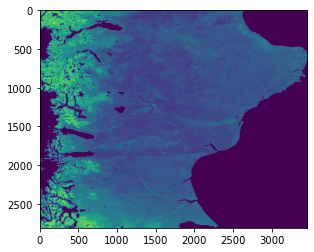

In [124]:
ds_soc = soc.sel(x=slice(-73.5778, -65.7107), y=slice(-45.9979, -52.3982)).copy()
ds_soc = ds_soc.fillna(0)
plt.imshow(ds_soc.values)

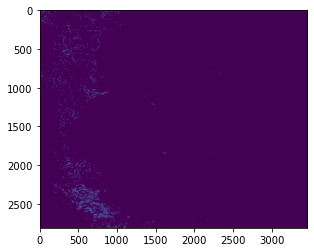

In [130]:
ds_dsoc = dsoc.sel(x=slice(-73.5778, -65.7107), y=slice(-45.9979, -52.3982)).copy()
ds_dsoc  = ds_dsoc.where(ds_dsoc != ds_dsoc.values.min()) 
ds_dsoc = ds_dsoc.fillna(0)
plt.imshow(ds_dsoc.values)

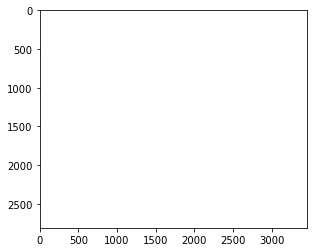

In [129]:
diff = ds_soc.values - ds_dsoc.values
plt.imshow(diff)

***
## Create `xarray.Dataset` in memory

### Argentina SOC stocks dataset

**Data location:**

https://storage.cloud.google.com/vizz-data-transfer/SOC_maps/

**Data description:**

The name structure of the files is `Feb19_cstocks_YEAR_030_ll.tif`:
- YEAR: 1982-2017
- The stocks were calculated in the 0 to 30 cm interval. 

**Output data location:**
 
https://storage.cloud.google.com/vizz-data-transfer/SOC_maps/soil-tnc-data.zarr/

**Create the `xarray.Dataset`**

In [ ]:
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_stock/'
ds_name = 'stocks'
depth = np.array(['0-30'])
times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
years = np.arange(1982, 1984, 1).astype(np.str)

for n, year in enumerate(years):
    print(f'Year: {year}')
    url = base_url + 'Feb19_cstocks_' + year + '_030_ll.tif'
    
    xda = xr.open_rasterio(url).squeeze().drop("band")
    
    # replace all values equal to -9999 with np.nan
    xda = xda.where(xda != -9999.) 
    
    # add time and depth coordinates
    xda = xda.assign_coords({"depth": depth[0], "time": times[n]}).expand_dims(['depht', 'time'])
    
    # convert to Dataset
    if n == 0:
        xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
    else:
        xds = xr.concat([xds, xr.Dataset({ds_name: xda}, attrs=xda.attrs)], dim='time')
        
    # select sub-area
    #xds = xds.isel(x=slice(2000, 2100), y=slice(4000, 4100))
xds

**Save `xarray.Dataset` as `Zarr` in Google Cloud Storage bucket**

In [ ]:
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))
#base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_stock/'
gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)

# Save in GCS
store = gc.get_mapper(root, check=False, create=True)
xds.to_zarr(store=store, group=group, mode='w', consolidated=True)
# consolidate metadata at root
zarr.consolidate_metadata(store)
c = gc.exists(f"{root}/.zmetadata")
print(f"{root} is consoldiated? {c}")
with zarr.open(store, mode='r') as z:
    print(z.tree())

**Save `xarray.Dataset` as `Zarr` in Amazon S3 bucket**

In [ ]:
# AWS S3 path
s3_path = 's3://soils-revealed/soil-data.zarr' 
group = 'experimental-dataset-stock'
# Initilize the S3 file system
s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))
store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
# Save to zarr
xds.to_zarr(store=store, group=group, mode='w', consolidated=True)

### Argentina SOC concentration dataset

**Input data location:**

https://storage.cloud.google.com/vizz-data-transfer/SOC_maps/

**Data description:**

The name structure of the files is `SOC_YEAR_qQUANTILE_dDEPTH.tif`:

- YEAR: 1982-2017
- QUANTILE: 0.05,0.5,0.95 percentiles
- DEPTH:
    - 2.5 --> for the interval 0-5cm
    - 10 --> for the interval 5-15cm
    - 22.5 --> for the interval 15-30cm
    - 45 --> for the interval 30-60cm
    - 80 --> for the interval 60-100cm
    - 150 --> for the interval 100-200cm

In [ ]:
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_concentration/'
ds_name = 'concentration'
times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
depths = {'0-5': '2.5', '5-15': '10', '15-30': '22.5', '30-60': '45', '60-100': '80', '100-200': '150'}
years = np.arange(1982, 1984, 1).astype(np.str)

for n, year in enumerate(years):
    for depth,dname in depths.items():
        print(f'Year: {year}')
        print(f'Depth: {depth}')
        url = base_url + 'SOC_' + year + '_q0.5_d'+ dname + '.tif'
        
        xda = xr.open_rasterio(url).squeeze().drop("band")
        
        # replace all values equal to 0 with np.nan
        xda = xda.where(xda != 0) 

        # add time and depth coordinates
        xda = xda.assign_coords({"depth": depth, "time": times[n]}).expand_dims(['depht', 'time'])
        
        # convert to Dataset and concatenate by depht
        if depth == '0-5':
            xds_depth = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
        else:
            xds_depth = xr.concat([xds_depth, xr.Dataset({ds_name: xda}, attrs=xda.attrs)], dim='depht')
            
    # select sub-area
    xds_depth = xds_depth.isel(x=slice(2000, 2100), y=slice(4000, 4100))
        
    # concatenate Datasets by time
    if n == 0:
        xds = xds_depth
    else:
        xds = xr.concat([xds, xds_depth], dim='time')
        
xds

**Save `xarray.Dataset` as `Zarr` in Google Cloud Storage bucket**

In [ ]:
local_path = '../data/soil-data.zarr'
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-concentration'
private_key = json.loads(os.getenv("PRIVATE_KEY"))
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_stock/'
gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)

# Save in GCS
store = gc.get_mapper(root, check=False, create=True)
store = gc.get_mapper(root)
xds.to_zarr(store=store, group=group, mode='w', consolidated=True)
# consolidate metadata at root
zarr.consolidate_metadata(store)
c = gc.exists(f"{root}/.zmetadata")
print(f"{root} is consoldiated? {c}")
with zarr.open(store, mode='r') as z:
    print(z.tree())

## Read `xarray.Dataset`

**Google Cloud Storage bucket**

In [ ]:
# Connect to GS
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))

gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)
store = gc.get_mapper(root)
# Check zarr is consolidated
#consolidated = gc.exists(f'{root}/.zmetadata')
# Cache the zarr store
#cache = zarr.LRUStoreCache(store, max_size=None)
# Return cached zarr group
ds_gcs = xr.open_zarr(store=store, group=group, consolidated=True)
ds_gcs

**Amazon S3 bucket**

In [ ]:
# AWS S3 path
s3_path = 's3://soils-revealed/soil-data.zarr' 
group = 'experimental-dataset-stock'
# Initilize the S3 file system
s3 = s3fs.S3FileSystem(key=os.getenv("S3_ACCESS_KEY_ID"), secret=os.getenv("S3_SECRET_ACCESS_KEY"))
sotre = s3fs.S3Map(root=s3_path, s3=s3, check=False)
# Read Zarr file
ds_s3 = xr.open_zarr(store=store, group=group, consolidated=True)
ds_s3

**Google Cloud Storage bucket**

In [ ]:
%%time
local_path = '../data/soil-data.zarr'
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))
ds_name = 'stocks'
base_url = 'https://storage.googleapis.com/vizz-data-transfer/SOC_maps/SOC_stock/'
gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)

times = pd.date_range("1982", "2018", freq='A-DEC', name="time")
depth = ['0-30']
years = np.arange(1982, 1985, 1).astype(np.str)

for i, year in enumerate(years):
    print(f'Year: {year}')
    url = base_url + 'Feb19_cstocks_' + year + '_030_ll.tif'
    xda = xr.open_rasterio(url).squeeze().drop("band")
    
    # replace all values equal to -9999 with np.nan
    xda = xda.where(xda != -9999.) 
    
    # add time and depth coordinates
    xda = xda.assign_coords({"depth": depth[0], "time": times[i]}).expand_dims(['depht', 'time'])
    
    # convert to Dataset
    xds = xr.Dataset({ds_name: xda}, attrs=xda.attrs)
    
    # select sub-area
    #xds = xds.isel(x=slice(2000, 2100), y=slice(4000, 4100))
    
    # save zarr into Google Cloud Storage bucket
    if i == 0:
        # Save in GCS
        #store = gc.get_mapper(root, check=False, create=True)
        #store = gc.get_mapper(root)
        #xds.to_zarr(store=store, group=group, mode='w', consolidated=True)
        # consolidate metadata at root
        #zarr.consolidate_metadata(store)
        #c = gc.exists(f"{root}/.zmetadata")
        #print(f"{root} is consoldiated? {c}")
        #with zarr.open(store, mode='r') as z:
        #    print(z.tree())
        
        # Save locally
        xds.to_zarr(local_path, group=group, mode='w', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(local_path)
        with zarr.open(local_path, mode='r') as z:
            print(z.tree())
    else:
        # Save in GCS
        #store = gc.get_mapper(root, check=True, create=False)
        #xds.to_zarr(store=store, group=group, mode='a', append_dim='time', consolidated=True)
        # consolidate metadata at root
        #zarr.consolidate_metadata(store)
        #c = gc.exists(f"{root}/.zmetadata")
        #print(f"{root} is consoldiated? {c}")
        #with zarr.open(store, mode='r') as z:
        #    print(z.tree())
        
        # Save locally
        xds.to_zarr(local_path, group=group, append_dim='time', consolidated=True)
        # consolidate metadata at root
        zarr.consolidate_metadata(local_path)
        with zarr.open(local_path, mode='r') as z:
            print(z.tree())

**Read `xarray.Dataset`**

In [ ]:
local_path = '../data/soil-data.zarr'
group = 'experimental-dataset'
ds_zarr = xr.open_zarr(local_path, group=group)
ds_zarr

In [ ]:
# Connect to GS
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset'
private_key = json.loads(os.getenv("PRIVATE_KEY"))

gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)
store = gc.get_mapper(root)
# Check zarr is consolidated
#consolidated = gc.exists(f'{root}/.zmetadata')
# Cache the zarr store
#cache = zarr.LRUStoreCache(store, max_size=None)
# Return cached zarr group
ds_gcs = xr.open_zarr(store=store, group=group, consolidated=True)
ds_gcs

[to_zarr append with gcsmap does not work properly #3251](https://github.com/pydata/xarray/issues/3251)